In [83]:
import torchvision
import torchvision.transforms as transforms
import torch
from matplotlib import pyplot as plt
import numpy as np

In [9]:
transform = transforms.ToTensor()

batch_size = 128

trainset = torchvision.datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

print("trainset:", len(trainset))
print("testset:", len(testset))


trainset: 60000
testset: 10000


In [82]:
# Shape of an example
print(f"Shape: {len(trainset[0][0][0])}, {len(trainset[0][0][0][0])}")

Shape: 28, 28


In [34]:
# All labels in training set
classes = set([y for _, y in trainset])
classes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [79]:
# Function to show images
def show_imgs(imgs):
    imgs_data = [img for img, _ in imgs]
    imgs_label = [label for _, label in imgs]
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(imgs_data):
        plt.subplot(1, len(imgs_data), i+1)
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("Labels:", imgs_label)

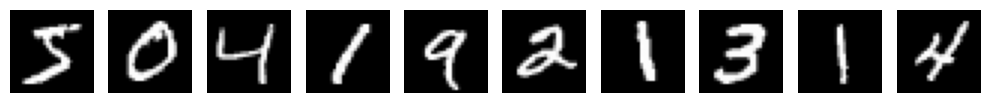

Labels: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [80]:
sample_imgs = [trainset[i] for i in range(10)]
show_imgs(sample_imgs)

In [213]:
class MNISTClassifier:
    def __init__(self, loss_fn, input_dim=784, hidden_dim=128, output_dim=10):
        self.loss_fn = loss_fn

        self.W1 = torch.tensor(np.random.randn(hidden_dim, input_dim))
        self.W2 = torch.tensor(np.random.randn(output_dim, hidden_dim))

        # internal biases for respective layers
        self.w1 = torch.zeros(hidden_dim)
        self.w2 = torch.zeros(output_dim)

        # prediction biases
        self.b1 = torch.zeros(hidden_dim)

        self.loss = None

    def forward(self, x):
        h1 = self.W1 @ x + self.w1
        y1 = torch.relu(h1) + self.b1

        h2 = self.W2 @ y1 + self.w2
        y2 = torch.softmax(h2, dim=0)
        return y2

    def backward(self, x, y_true):
        h1 = self.W1 @ x + self.w1
        y1 = torch.relu(h1) + self.b1

        h2 = self.W2 @ y1 + self.w2
        y2 = torch.softmax(h2, dim=0)

        dy2 = y2.clone()
        dy2[y_true] -= 1

        # Gradients for second layer 
        dW2 = torch.outer(dy2, y1)
        dw2 = dy2
        db2 = dy2
    
        # First layer gradients
        dy1 = self.W2.T @ dy2 
        dh1 = dy1 * (h1 > 0).float()  # ReLU derivative
        dW1 = torch.outer(dh1, x)
        dw1 = dh1
        db1 = dy1

        # Update weights
        lr = 0.01
        self.W2 -= lr * dW2
        self.w2 -= lr * dw2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.w1 -= lr * dw1
        self.b1 -= lr * db1
        


    def loss(self, y_pred, y_true):
        self.loss = self.loss_fn(y_pred, y_true)
        return self.loss_fn(y_pred, y_true)

In [211]:
# Shape of single exanple
trainset[0][0].shape # requires reshaping to 784 features

x = np.float64(trainset[0][0].reshape(784))

In [212]:
# Dummy model (untrained)
dummy = MNISTClassifier(loss_fn=None)
dummy_out = dummy.forward(x) # outputs probabilities for each class
dummy_out

/var/folders/qt/p78tc4gx2576_n2rl38t_gwr0000gn/T/ipykernel_19092/3679940817.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  h1 = self.W1 @ x + self.w1
/var/folders/qt/p78tc4gx2576_n2rl38t_gwr0000gn/T/ipykernel_19092/3679940817.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y1 = np.maximum(0, h1) + self.b1
/var/folders/qt/p78tc4gx2576_n2rl38t_gwr0000gn/T/ipykernel_19092/3679940817.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  exp_h2 = np.exp(h2)


TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [198]:
# Define loss functions
def cross_entropy_loss(out, y):
    """
    idea: softmax outputs very small values (probabiltiies) for each class:
        - take log of values to get bigger values (negative)
        - take negative of log to get positive values
        - if out[y] = 0, then -log(out[y]) = inf, so add a small value to avoid this
    """
    return -np.log(out[y] + 1e-10)

def mse_loss(out, y):
    out_ohe = np.zeros_like(out)
    return np.sum((out_ohe - y)**2)

In [205]:
model = MNISTClassifier(loss_fn=cross_entropy_loss)
out = model.forward(x)
out

/var/folders/qt/p78tc4gx2576_n2rl38t_gwr0000gn/T/ipykernel_19092/3520513835.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  h1 = self.W1 @ x + self.w1


tensor([ 1.5618e-63,  7.4983e-73,  9.1680e-52,  1.3703e-66, 3.2184e-105,
         1.0000e+00,  1.3626e-61,  1.7315e-96, 4.1539e-111,  6.3018e-55],
       dtype=torch.float64)

In [206]:
# Test the loss function
model.loss(out, trainset[0][1]).item()

/var/folders/qt/p78tc4gx2576_n2rl38t_gwr0000gn/T/ipykernel_19092/2917070253.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -np.log(out[y] + 1e-10)


-1.000000082690371e-10